# Credit Card User Segmentation

You work as a data scientist at a credit card company. A senior VP is leading an effort to reduce costs associated with signup incentives by offering credit cards with carefully targeted benefits that will attract new cardholders. As a first step, she would like you to examine cardholder data collected over the last 6 months in order to understand the various kinds of users who use the company’s products. She is especially interested in getting an idea of which benefits to associate with each new card offering.

**Goal**

Reduce costs associated with signup incentives by offering credit cards with carefully targeted benefits that will attract new cardholders. 
* What min incentives can we offer to customers to have the largest impact on number of signups?
* Can we increase signups and reduce costs by "personalizing" incentives by customer segments?

**Findings**
- Three general customer categories were found: (1) Low-value clients, (2) High Borrowers, (3) High-Value clients
- This indicates that personalized incentives make sense, for example, incentives to purchase given to high-value clients will show better return on investments.
- Also, customers with higher tenure seem to have higuer *Balance* and *Purchases*. However, the *Balance to Purchase ratio* indicates that older tenure does not imply higher purchase values. Customers may make more use of credit but the value of their purchases is less. 
- This finding too indicates that personalized incentives based on card tenure make sense, for example, customers using the card frequently can be incentivized to reach certain spending goals.
- Finally, we identified that average balance is increased by 2014 dollars per every additional cash-advance. So, balance value is highly influenced by cash-advances and customers could be incentivized to do more cash-advances or to increase their balances by setting specific usage goals.

In [2]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import warnings
warnings.filterwarnings("ignore")
from pylab import rcParams
from sklearn.model_selection import train_test_split
%matplotlib inline

## Step 1: Examine cardholder data collected over the last 6 months

In [4]:
file = 'https://raw.githubusercontent.com/Insight-DS-West/CreditCardUserSegmentation/master/cc_info.csv?token=ABFZSC3JYOENNMGMY6YFXPS73JC7I'
cc_info = pd.read_csv(file, error_bad_lines=False)
cc_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [37]:
cc_info.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


### Data exploration and cleansing

#### Identify Highly Correlated Features

In [6]:
# Create correlation matrix
corr_matrix = cc_info.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
BALANCE,NaN,0.322412,0.181261,0.164350,0.126469,0.496692,0.077944,0.073166,0.063186,0.449218,0.385152,0.154338,0.531283,0.322802,0.398684,0.318959,0.072692
BALANCE_FREQUENCY,NaN,NaN,0.133674,0.104323,0.124292,0.099388,0.229715,0.202415,0.176079,0.191873,0.141555,0.189626,0.095843,0.065008,0.132569,0.095082,0.119776
PURCHASES,NaN,NaN,NaN,0.916845,0.679896,0.051474,0.393017,0.498430,0.315567,0.120143,0.067175,0.689561,0.356963,0.603264,0.093860,0.180379,0.086288
ONEOFF_PURCHASES,NaN,NaN,NaN,NaN,0.330622,0.031326,0.264937,0.524891,0.127729,0.082628,0.046212,0.545523,0.319724,0.567292,0.048755,0.132763,0.064150
INSTALLMENTS_PURCHASES,NaN,NaN,NaN,NaN,NaN,0.064244,0.442418,0.214042,0.511351,0.132318,0.073999,0.628108,0.256499,0.384084,0.132172,0.182569,0.086143
CASH_ADVANCE,NaN,NaN,NaN,NaN,NaN,NaN,0.215507,0.086754,0.177070,0.628522,0.656498,0.075850,0.303985,0.453238,0.140107,0.152935,0.068312
PURCHASES_FREQUENCY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.501343,0.862934,0.308478,0.203478,0.568430,0.119788,0.103464,0.003030,0.305802,0.061506
ONEOFF_PURCHASES_FREQUENCY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.142329,0.111716,0.069088,0.544869,0.295038,0.243537,0.030327,0.157531,0.082466
PURCHASES_INSTALLMENTS_FREQUENCY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.262958,0.169207,0.529975,0.060755,0.085551,0.030073,0.250087,0.073275
CASH_ADVANCE_FREQUENCY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.799561,0.131168,0.132616,0.183192,0.098838,0.249773,0.133372


In [7]:
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
to_drop

['ONEOFF_PURCHASES', 'PURCHASES_INSTALLMENTS_FREQUENCY']

In [8]:
# Drop features 
cc_df = cc_info.drop(cc_info[to_drop],axis = 1)
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CUST_ID                     8950 non-null   object 
 1   BALANCE                     8950 non-null   float64
 2   BALANCE_FREQUENCY           8950 non-null   float64
 3   PURCHASES                   8950 non-null   float64
 4   INSTALLMENTS_PURCHASES      8950 non-null   float64
 5   CASH_ADVANCE                8950 non-null   float64
 6   PURCHASES_FREQUENCY         8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY  8950 non-null   float64
 8   CASH_ADVANCE_FREQUENCY      8950 non-null   float64
 9   CASH_ADVANCE_TRX            8950 non-null   int64  
 10  PURCHASES_TRX               8950 non-null   int64  
 11  CREDIT_LIMIT                8949 non-null   float64
 12  PAYMENTS                    8950 non-null   float64
 13  MINIMUM_PAYMENTS            8637 

#### Conduct Variance Thresholding

In [9]:
cc_df.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')

In [10]:
mycols = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']
X = cc_df[mycols]

In [15]:
from sklearn.feature_selection import VarianceThreshold

# Create VarianceThreshold object with a variance with a threshold of 0.5
thresholder = VarianceThreshold(threshold=.5)

# Conduct variance thresholding
X_high_variance = thresholder.fit_transform(X)

# View first five rows with features with variances above threshold
X_high_variance[0:3]

array([[4.09007490e+01, 9.54000000e+01, 9.54000000e+01, 0.00000000e+00,
        0.00000000e+00, 2.00000000e+00, 1.00000000e+03, 2.01802084e+02,
        1.39509787e+02, 1.20000000e+01],
       [3.20246742e+03, 0.00000000e+00, 0.00000000e+00, 6.44294548e+03,
        4.00000000e+00, 0.00000000e+00, 7.00000000e+03, 4.10303260e+03,
        1.07234022e+03, 1.20000000e+01],
       [2.49514886e+03, 7.73170000e+02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.20000000e+01, 7.50000000e+03, 6.22066742e+02,
        6.27284787e+02, 1.20000000e+01]])

In [ ]:
X_high_variance.columns

In [ ]:
# Drop features 
cc_df = cc_df.drop(cc_info[X_high_variance],axis = 1)
cc_df.info()

#### Drop nulls

In [19]:
#Alternative, percentage  (%) of nulls
X.isnull().mean() * 100

BALANCE                       0.000000
BALANCE_FREQUENCY             0.000000
PURCHASES                     0.000000
INSTALLMENTS_PURCHASES        0.000000
CASH_ADVANCE                  0.000000
PURCHASES_FREQUENCY           0.000000
ONEOFF_PURCHASES_FREQUENCY    0.000000
CASH_ADVANCE_FREQUENCY        0.000000
CASH_ADVANCE_TRX              0.000000
PURCHASES_TRX                 0.000000
CREDIT_LIMIT                  0.011173
PAYMENTS                      0.000000
MINIMUM_PAYMENTS              3.497207
PRC_FULL_PAYMENT              0.000000
TENURE                        0.000000
dtype: float64

In [20]:
X = X.dropna()
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8636 entries, 0 to 8949
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   BALANCE                     8636 non-null   float64
 1   BALANCE_FREQUENCY           8636 non-null   float64
 2   PURCHASES                   8636 non-null   float64
 3   INSTALLMENTS_PURCHASES      8636 non-null   float64
 4   CASH_ADVANCE                8636 non-null   float64
 5   PURCHASES_FREQUENCY         8636 non-null   float64
 6   ONEOFF_PURCHASES_FREQUENCY  8636 non-null   float64
 7   CASH_ADVANCE_FREQUENCY      8636 non-null   float64
 8   CASH_ADVANCE_TRX            8636 non-null   int64  
 9   PURCHASES_TRX               8636 non-null   int64  
 10  CREDIT_LIMIT                8636 non-null   float64
 11  PAYMENTS                    8636 non-null   float64
 12  MINIMUM_PAYMENTS            8636 non-null   float64
 13  PRC_FULL_PAYMENT            8636 

In [21]:
# Create training and test sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=1)

#### Data Exploration

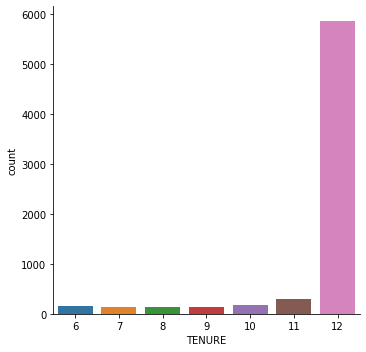

In [22]:
sns.catplot(x='TENURE', kind='count', data = X_train)

In [23]:
# Top events by type and users (%)
X_train['TENURE'].value_counts(normalize=True).sort_values(ascending=False).head()

12    0.849160
11    0.041836
10    0.026202
6     0.022872
8     0.020411
Name: TENURE, dtype: float64

## Modeling

##### Affinity propagation

In [46]:
# affinity propagation clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import AffinityPropagation
from matplotlib import pyplot

In [47]:
# define the model
model = AffinityPropagation(damping=0.9)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
#for cluster in clusters:
	# get row indexes for samples with this cluster
	#row_ix = where(yhat == cluster)
	# create scatter of these samples
	#pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
#pyplot.show()

In [48]:
model.labels_

array([242, 268, 156, ..., 242, 325, 252], dtype=int64)

##### K-means

In [24]:
# Load libraries
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [25]:
# Standarize features
scaler = StandardScaler()
X_std = scaler.fit_transform(X_train)

In [26]:
# Create k-mean object
clt = KMeans(n_clusters=3, random_state=0, n_jobs=-1)

# Train model
model = clt.fit(X_std)

In [27]:
# View predict class
model.labels_

array([0, 1, 0, ..., 1, 0, 2])

In [28]:
X_train['cluster_label'] = model.labels_
X_train

,BALANCE,BALANCE_FREQUENCY,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster_label
1056,39.376180,1.000000,256.50,256.50,0.000000,0.750000,0.000000,0.000000,0,9,1200.0,164.372670,131.106729,0.166667,12,0
4966,2659.411879,1.000000,177.62,0.00,1831.115496,0.166667,0.166667,0.583333,19,4,4000.0,577.131439,624.924987,0.000000,12,1
166,823.103926,0.363636,131.64,131.64,0.000000,1.000000,0.000000,0.000000,0,12,8000.0,2916.071564,243.199498,0.000000,12,0
4865,503.732786,1.000000,1730.30,329.15,0.000000,0.916667,0.583333,0.000000,0,21,2500.0,2293.371099,179.553478,0.083333,12,0
582,7088.358802,1.000000,0.00,0.00,3118.050456,0.000000,0.000000,0.083333,2,0,7500.0,4539.526102,2183.319473,0.000000,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3014,1310.839573,1.000000,646.28,224.11,2350.427153,0.666667,0.333333,0.416667,17,15,1500.0,1758.379933,908.470064,0.000000,12,1
8077,1127.633173,1.000000,422.55,0.00,150.157754,0.333333,0.333333,0.083333,1,8,1200.0,167.203806,3078.975540,0.000000,12,0
977,5573.146558,1.000000,435.14,0.00,3935.733135,1.000000,1.000000,0.333333,7,14,7000.0,1587.909833,1390.110596,0.000000,12,1
5367,4375.764064,1.000000,1016.41,1016.41,252.583938,0.916667,0.000000,0.083333,1,12,10000.0,1133.806322,1165.418430,0.000000,12,0


In [29]:
X_train.groupby(["cluster_label"]).describe()

BALANCE                                                    \
                count         mean          std        min          25%   
cluster_label                                                             
0              4593.0   851.187329   984.682458   0.000000    69.920933   
1              1160.0  4195.193945  2687.467957  51.422178  2086.049348   
2              1155.0  1973.974528  2467.996322   4.382924   293.077222   

                                                      BALANCE_FREQUENCY  \
                       50%          75%           max             count   
cluster_label                                                             
0               495.162530  1300.793883   8115.039014            4593.0   
1              3747.878352  5824.958408  16304.889250            1160.0   
2               975.416023  2818.710146  19043.138560            1155.0   

                         ... PRC_FULL_PAYMENT       TENURE             \
                   mean  ...              75%  max   count       mean   
cluster_label            ...                                            
0              0.856232  ...         0.166667  1.0  4593.0  11.470934   
1              0.962674  ...         0.000000  1.0  1160.0  11.384483   
2              0.980856  ...         0.666667  1.0  1155.0  11.899567   

                                                      
                    std  min   25%   50%   75%   max  
cluster_label                                         
0              1.394237  6.0  12.0  12.0  12.0  12.0  
1              1.477622  6.0  12.0  12.0  12.0  12.0  
2              0.620525  6.0  12.0  12.0  12.0  12.0  

[3 rows x 120 columns]

In [30]:
X_train.groupby(["cluster_label"]).mean()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
cluster_label,,,,,,,,,,,,,,,
0,851.187329,0.856232,473.128783,241.773490,380.375057,0.435874,0.106283,0.078571,1.405617,7.960374,3158.867161,949.032492,557.563940,0.155371,11.470934
1,4195.193945,0.962674,489.852112,181.227517,4105.536482,0.266124,0.123982,0.463713,13.324138,7.121552,7021.512539,3272.555515,1889.200778,0.036559,11.384483
2,1973.974528,0.980856,3756.688667,1374.764952,310.960177,0.944066,0.677872,0.048902,1.019048,50.843290,7426.103896,3665.832158,1144.552095,0.306540,11.899567


In [31]:
X_train['Balance/Purchase'] = X_train.BALANCE/X_train.PURCHASES
X_train.groupby(["cluster_label"]).mean()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Balance/Purchase
cluster_label,,,,,,,,,,,,,,,,
0,851.187329,0.856232,473.128783,241.773490,380.375057,0.435874,0.106283,0.078571,1.405617,7.960374,3158.867161,949.032492,557.563940,0.155371,11.470934,inf
1,4195.193945,0.962674,489.852112,181.227517,4105.536482,0.266124,0.123982,0.463713,13.324138,7.121552,7021.512539,3272.555515,1889.200778,0.036559,11.384483,inf
2,1973.974528,0.980856,3756.688667,1374.764952,310.960177,0.944066,0.677872,0.048902,1.019048,50.843290,7426.103896,3665.832158,1144.552095,0.306540,11.899567,1.519682


**Findings:**
- We seem to have three general customer categories: (0) Low-value clients, (1) High Borrowers, (2) High-Value clients
- This indicates that personalized incentives make sense, for example, incentives to purchase given to high-value clients will show better return on investments.

*Note:*
In this case we used K-means for exploring our data and to determine atributes of customer groups, not with the goal of predictive analysis.

#### Diferences by tenure time:

In [36]:
TENURE = X_train.groupby('TENURE').mean().reset_index()
TENURE['Balance/Purchase'] = TENURE.BALANCE/TENURE.PURCHASES
TENURE['cluster_label'] = TENURE['cluster_label'].astype(str)
TENURE.head(12)

,TENURE,BALANCE,BALANCE_FREQUENCY,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,cluster_label,Balance/Purchase
0,6,1167.682083,0.835443,476.892089,198.327595,1509.464641,0.482067,0.139241,0.257384,4.151899,6.056962,2902.025316,734.110801,345.482401,0.227426,0.3227848101265823,2.448525
1,7,1014.896742,0.855087,416.259928,189.974245,1146.142740,0.461459,0.130524,0.217883,3.604317,6.366906,2415.827338,676.837673,402.185053,0.137359,0.2014388489208633,2.438132
2,8,1248.046773,0.832447,464.791348,179.779929,1477.141935,0.437943,0.147163,0.204787,4.794326,6.624113,3054.255319,901.271108,431.662567,0.176494,0.28368794326241137,2.685176
3,9,1227.930796,0.822554,588.196716,254.789701,1598.145421,0.431177,0.118574,0.223051,4.731343,7.231343,3014.925373,1010.556876,545.261227,0.180787,0.31343283582089554,2.087619
4,10,1309.394413,0.822652,578.142210,228.981492,1339.578884,0.388950,0.137569,0.183978,4.127072,7.745856,3898.342541,1087.649604,470.490495,0.170955,0.3149171270718232,2.264831
5,11,1732.043242,0.880466,531.376159,182.039758,1478.393762,0.349481,0.144700,0.183391,5.328720,6.923875,4270.415225,1600.518587,1031.186902,0.122270,0.3460207612456747,3.259543
6,12,1645.452836,0.903589,1115.668239,459.811621,916.925781,0.506279,0.216743,0.126023,3.125639,16.433515,4715.659975,1919.046801,928.525500,0.160188,0.5373337879304466,1.474859


**Findings:** 
- Customers with higher tenure seem to have higuer *Balance* and *Purchases*. However, the *Balance to Purchase ratio* indicates that older tenure does not imply higher purchase values. Customers may make more use of credit but the value of their purchases is less. 
- This finding also indicates that personalized incentives based on card tenure make sense, for example, customers using the card frequently can be incentivized to reach certain spending goals.



##### Linear Regression

Let's try a second model to determine what factors are having an impact on *Balance*:

In [42]:
features = ['BALANCE_FREQUENCY', 'PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']
target = ['BALANCE']

In [43]:
# Store features, target, and number of observations
X = X_train[features].values
y = X_train[target].values
n = X_train.shape[0]

In [44]:
# Calculate mean balance value for benchmark
y_mean = np.mean(y)
y_mean

1600.4442613488711

In [45]:
# Calculate benchmark RMSE
RMSE_benchmark = np.sqrt(np.sum((y - y_mean)**2) / n)
RMSE_benchmark

2097.8467942984275

In [47]:
# Build linear regression model
from sklearn.linear_model import LinearRegression
np.random.seed(0)   # setting random seed for reproducibility

lr = LinearRegression()
lr.fit(X, y)

# Make predictions
X_train['predictions'] = lr.predict(X)
y_pred = X_train['predictions'].values

In [48]:
# Calculate RMSE for linear regression model
RMSE_lr = np.sqrt(np.sum((y - y_pred)**2) / n)
RMSE_lr

222025.44124845657

In [55]:
# View the intercept
lr.intercept_

array([-1379.8075073])

In [54]:
# View the feature coefficients
lr.coef_

array([[ 1.64267115e+03,  1.04789472e-01, -7.94900309e-02,
         2.23226629e-01, -2.43620507e+02, -4.61868119e+02,
         2.01421108e+03, -1.84388381e+01,  6.67510956e+00,
         2.36233678e-01, -3.00129024e-02,  1.99834984e-01,
        -1.56407421e+03,  1.50323969e+01]])

**Findings:** 
- Average balance is increased by 2014 dollars per every additional cash-advance. So, balance value is highly influenced by cash-advances. 
- Also, the ratio between *Balance* and *Purchase* increases by $15 the average user balance per additional month of tenure. 

Let's now visualize how good is the new model for predicting *Balance*

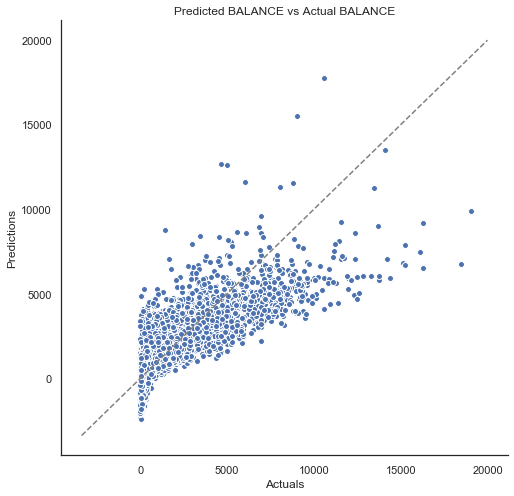

In [52]:
# Create scatter to compare predictions to actual sale prices
## Set style
sns.set(style='white', palette='deep', rc={'figure.figsize':[8, 8]})

## Plot scatterplot for predictions and actual prices
fig, ax = plt.subplots()
ax.scatter(x=X_train['BALANCE'], y=X_train['predictions'], edgecolor='white')
ax.set_title('Predicted BALANCE vs Actual BALANCE')
ax.set_xlabel('Actuals')
ax.set_ylabel('Predictions')

## Plot gray dotted diagonal line (where markers should lie if predictions = actual)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),   # find min limits of figure
    np.max([ax.get_xlim(), ax.get_ylim()])    # find max limits of figure
]
ax.plot(lims, lims, color='0.5', linestyle='--')

## Remove top and right spines
sns.despine()
plt.show()

This model shows an extremely high residual error, try tuning the model to improve this value.